Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from scipy import optimize
import pandas as pd
from keras.datasets import mnist
from time import process_time
from IPython.display import clear_output

np.random.seed(1337)

def tic():
  global ticc
  ticc=process_time()

def toc():
  tocc=process_time()
  print("\nTime elapsed: ",(tocc-ticc)) #easily measure time spent

# **Week 4**

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#turn Nx28x28 array into Nx784 and into matlab double
x_train = x_train.reshape(60000, 784).astype('float64')
x_test = x_test.reshape(10000, 784).astype('float64')

#get 3 and 7
con=np.where((y_train==3)|(y_train==7))
x_train=x_train[con]
y_train=y_train[con]
con2=np.where((y_test==3)|(y_test==7))
x_test=x_test[con2]
y_test=y_test[con2]

#dimensions
N=x_train.shape[0]
d=x_train.shape[1]

#normalize
x_train=x_train/np.amax(x_train)
x_test=x_test/np.amax(x_test)
y_train=(y_train-3)/4
y_test=(y_test-3)/4

y_train=np.array([y_train]).T
y_test=np.array([y_test]).T

#add x0 column
x_train=np.concatenate((np.array([np.ones(x_train.shape[0])]).T, x_train), 1)
x_test=np.concatenate((np.array([np.ones(x_test.shape[0])]).T, x_test), 1)

11493376/11490434 [==============================] - 0s 0us/step


## Gradient Methods

*In this exercise you will program and learn different learning algorithms. As an example we consider the logistic regression problem, which is not too simple (it is non-linear in the parameters) and not too hard (it has a unique solution). Inputs patterns $x^n = (x^n_1, . . ., x^n_d) \in R^d$ output patterns $t^n = \{0, 1\}$ with $n = 1, . . . , N$ and $N$ the total number of patterns. The model is given as (see also Bishop section 4.3) follows. The probability of $t = 1$ given $x$ is given by*

$$y = p(t=1\mid x) = \sigma \left(\sum^d_{i=0} w_i x_i \right)$$

In [3]:
def sigma(x):
  return (1+np.exp(-x))**-1

def predict(x,w):
  return sigma(np.dot(x, w))

*where we have defined $x^n_0= 1$ and $\sigma$ is the sigma function $σ(x)= (1 + e^{−x}))^{−1}$ and $p(t=0\mid x) = 1 − y$. Define $y^n = p(t = 1\mid x^n)$. The cost to be minimizes is minus the log likelihood of the data*
$$E(w) = -\frac{1}{N}\sum^N_{n=1}[t^n log y^n + (1 − t^n) log(1 − y^n)]$$

In [4]:
def E(x,t,w):
  y=sigma(np.dot(x, w))
  return -np.mean(t*np.log(y)+(1-t)*np.log(1-y))

*The gradient and Hessian are*

$$\nabla_i E(w) =\frac{\partial E}{\partial w_i}=\frac{1}{N}\sum^N_{n=1}(y^n − t^n)x^n_i \qquad i = 0, . . . , d$$

$$H_{ij}(w) =\frac{\partial^2E}{\partial w_i\partial w_j}=\frac{1}{N}\sum_n x^n_i y^n(1 − y^n)x^n_j \qquad i, j = 0, . . . , d$$

In [5]:
def Grad(x,t,w):
  y=predict(x,w)
  return np.expand_dims(np.mean((y-t)*x,axis=0),axis=1)

def Hess(i,j,x,t,w):
  y=predict(x,w)
  return np.mean(x[:,[i]]*y*(1-y)*x[:,[j]])

def getH(d,x,t,w):
  H=np.zeros((d+1,d+1))
  for i in range(d+1):
    for j in range(d+1):
      H[i,j]=Hess(i,j,x,t,w)
  return H

def getHfast(x,t,w):
  y=predict(x,w)
  middlematrix=np.diagflat((y*(1-y)).T)
  H1=np.matmul(np.matmul(x.T, middlematrix),x)
  return H1

*The 1/N term is just to make the quantities of order 1 for numerical stability. Test the different learning methods on the MNIST data http://yann.lecun.com/exdb/mnist/. The data in matlab format are here: http://www.snn.ru.nl/˜bertk/comp_neurosci/mnistAll.mat. These are images of digits 0 to 9. Select the images 3 and 7 for your two class classification problem. Scale the inputs to be in
the range [0, 1].*

### Gradient descent

*The simplest idea to minimize E is by gradient descent. Start with random initial w and update according to*

$$\Delta w_i = -\eta \frac{\partial E}{\partial w_i}$$

*Implement the learning rule in your computer program. Apply the method to the logistic regression problem. Produce plots of how E decreases with iterations, both on the training set and on the test set. Note, that the training error should always decrease, but the test error not. Stopping at the point where the test error increases is called early stopping, and produces a result with relatively good generalization error. Discuss the
drawbacks of early stopping. Test the effect of different values of $\eta$. Here are some results that I got after 10.000 iterations:*

$$E_{train} = 0.0184\qquad E_{test} = 0.0511$$

*The fraction of misclassified patterns is 1.14% and 2.05% on train and test set respectively. CPU time Matlab implementation was 45 s.*

In [6]:
class Regressor():
  def __init__(self, d, eta):

    # Learning rate eta
    self.eta = eta

    #Start with random w vector
    self.w = np.random.randn(d+1,1) #np.zeros((d+1,1))

    # Array to keep track of cost and error for plotting purposes
    self.E_train_array=[]
    self.E_test_array=[]
    self.train_error_array=[]
    self.test_error_array=[]
    self.run_array=[]

    self.checking_rate=100

  # Trains the perceptron
  def train(self, nruns,x_train,y_train,x_test,y_test):
    # Number of epochs
    for i in np.arange(1,nruns+1):
      if i%int(nruns/self.checking_rate)==0:
        print("\r","Iterations complete: ",i*100/nruns,"%", end="")
        self.solve(i,x_train,y_train,x_test,y_test)
      elif i==nruns:  #
        print("\r","Iterations complete: ",i*100/nruns,"%", end="")
        self.solve(i,x_train,y_train,x_test,y_test)
  
      # Actually trains the perceptron
      self.update(x_train,y_train)
      

  # Learning rule
  def update(self,x,t):
    self.w += -self.eta * Grad(x,t,self.w)

  # Calculate cost/error and append it to arrays
  def solve(self,i,x_train,y_train,x_test,y_test):
    self.run_array.append(i) 

    self.E_train_array.append(E(x_train,y_train,self.w))
    self.E_test_array.append(E(x_test,y_test,self.w))

    sol_train=predict(x_train,self.w)
    train_error=np.mean(np.not_equal(sol_train>0.5,y_train))

    sol_test=predict(x_test,self.w)  
    test_error=np.mean(np.not_equal(sol_test>0.5,y_test)) 

    self.train_error_array.append(train_error)
    self.test_error_array.append(test_error)

  # Plot cost/error curves
  def plot_regressor(self):
    plt.plot(self.run_array,self.E_train_array,label="E_train")
    plt.plot(self.run_array,self.E_test_array,label="E_test")
    plt.legend()

    plt.figure()
    plt.plot(self.run_array,self.train_error_array,label="Train error")
    plt.plot(self.run_array,self.test_error_array,label="Test error")
    plt.legend()

  # Display final cost/error
  def print_regressor(self):
    print("E_train: ",self.E_train_array[-1])
    print("E_test: ",self.E_test_array[-1])
    print("Error train: ",self.train_error_array[-1]*100,"%")
    print("Error test: ",self.test_error_array[-1]*100,"%")


This regressor will just run a set number of epochs, it could be that the regressor starts overfitting and a smaller number of epochs is more optimal. We can try a few algorithms that try to predict when the cost is going up and then quit the training. But this shouldn't quit too soon, for instance we could be at only at a temporary increase in the cost where more epochs would still decrease the cost even more. For this reason we test a few algorithms with a few different "patience" parameter values on an already completed regressor with a record of the cost at every epoch.


In [ ]:
# Simply count number of times the cost goes up
def count_stopper(cost_array, patience):
  print("Minimum at: ",np.min(cost_array)," index: ", np.argmin(cost_array))
  j=0
  cost_prev=cost_array[0]
  completed=True
  for i, cost in enumerate(cost_array):
    if j>patience:
      print("Early stopping at: ", cost_array[i], "index: ", i)
      completed=False
      break
    if cost>cost_prev:
      j+=1
      cost_prev=cost
    else:
      j=0
      cost_prev=cost
  if completed: print("Did not stop early")

# Patience is the number of values to average over, shift is how far the two averages to be compared are apart from eachother
def average_stopper(cost_array, patience, shift):
  print("Minimum at: ",np.min(cost_array)," index: ", np.argmin(cost_array))
  completed=True
  for i in range(len(cost_array)):
    c_array=cost_array[:i+1]
    trend=np.mean(c_array[-(patience+shift):-(1+shift)])-np.mean(c_array[-patience:-1])
    if trend<-1e5:
      print("Early stopping at: ", cost_array[i], "index: ", i)
      completed=False
      break
      
  if completed: print("Did not stop early")

In [ ]:
# Get array from normal regressor with cost values, we want a value at every epoch so checking rate should be same as nruns
nruns=20000
test_regressor=Regressor(d,eta=1)
test_regressor.checking_rate=nruns
test_regressor.train(nruns,x_train,y_train,x_test,y_test)

test_regressor.print_regressor()

cost_array=test_regressor.E_test_array

 Iterations complete:  100.0 %E_train:  0.015544642825910128
E_test:  0.06642660375124412
Error train:  0.4275572765408196 %
Error test:  1.7664376840039255 %


In [ ]:
for patience in range(1,5):
  print("Patience: ",patience)
  count_stopper(cost_array, patience)

Patience:  1
Minimum at:  0.0646527348658473  index:  7801
Early stopping at:  0.06465273519392184 index:  7804
Patience:  2
Minimum at:  0.0646527348658473  index:  7801
Early stopping at:  0.06465273548237972 index:  7805
Patience:  3
Minimum at:  0.0646527348658473  index:  7801
Early stopping at:  0.06465273586031275 index:  7806
Patience:  4
Minimum at:  0.0646527348658473  index:  7801
Early stopping at:  0.06465273632767526 index:  7807


In [ ]:
shift=1
for patience in range(3,8):
  print("Patience: ",patience)
  average_stopper(cost_array, patience, shift)

Patience:  3
Minimum at:  0.0646527348658473  index:  7801


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not stop early
Patience:  4
Minimum at:  0.0646527348658473  index:  7801
Did not stop early
Patience:  5
Minimum at:  0.0646527348658473  index:  7801
Did not stop early
Patience:  6
Minimum at:  0.0646527348658473  index:  7801
Did not stop early
Patience:  7
Minimum at:  0.0646527348658473  index:  7801
Did not stop early


It seems a simple count stopper should do well enough

In [ ]:
class EarlyStopRegressor(Regressor):
  def __init__(self, d, eta):
    super().__init__(d, eta)
    self.patience=3
    self.cost_prev=0

  def train(self, nruns,x_train,y_train,x_test,y_test):
    j=0
    # Number of epochs
    for i in np.arange(1,nruns+1):
      if i%int(nruns/self.checking_rate)==0:
        print("\r","Iterations complete: ",i*100/nruns,"%", end="")
        if not not self.E_test_array:
          cost=self.E_test_array[-1]
          if j>self.patience:
            print("Early stopping")
            break
          if cost>self.cost_prev:
            j+=1
          else:
            j=0
          self.cost_prev=cost
          
        self.solve(i,x_train,y_train,x_test,y_test)
      elif i==nruns:  #
        print("\r","Iterations complete: ",i*100/nruns,"%", end="")
        self.solve(i,x_train,y_train,x_test,y_test)
  
      # Actually trains the perceptron
      self.update(x_train,y_train)

Drawbacks of early stopping:

You might just be at a temporary increasing training error phase, running for even longer might return you to a regime where training error is decreasing again, this can be mitigated by increasing "patience" factor

Also slows down the algorithm a bit.

#### Optimise eta functions:

In [ ]:
def test_eta(d,eta_vals, nruns):
  regressors = [Regressor(d,eta) for eta in eta_vals]

  E_train_array_eta, E_test_array_eta, train_error_array_eta, test_error_array_eta = [[] for _ in range(4)]

  for i,regressor in enumerate(regressors):

    print("\nTraining regressor ",i)

    regressor.train(nruns,x_train,y_train,x_test,y_test)
  
    E_train_array_eta.append(regressor.E_train_array)
    E_test_array_eta.append(regressor.E_test_array)
    train_error_array_eta.append(regressor.train_error_array)
    test_error_array_eta.append(regressor.test_error_array)

  return np.array(E_train_array_eta), np.array(E_test_array_eta), np.array(train_error_array_eta), np.array(test_error_array_eta)



In [ ]:
def fullplot(nruns,eta_vals,E_train_array_eta,E_test_array_eta,train_error_array_eta,test_error_array_eta):
  fig = plt.figure(figsize=(18,5))
  ax1 = fig.add_subplot(141)
  ax2 = fig.add_subplot(142)
  ax3 = fig.add_subplot(143)
  ax4 = fig.add_subplot(144)

  for e,et in enumerate(eta_vals):
    X = np.linspace(0,nruns,100)
    lab="$\eta=$"+str(round(et,3))
    ax1.plot(X,E_train_array_eta[e,:],label=lab)
  ax1.set_title("E Train")
  ax1.set_xlabel("Iterations")
  ax1.set_xlabel("Iterations")
  ax1.set_ylim(0,0.1)

  for e,et in enumerate(eta_vals):
    X = np.linspace(0,nruns,100)
    lab="$\eta=$"+str(round(et,3))
    ax2.plot(X,E_test_array_eta[e,:],label=lab)
  ax2.set_title("E Test")
  ax2.set_xlabel("Iterations")
  ax2.set_xlabel("Iterations")
  ax2.set_ylim(0.05,0.1)

  for e,et in enumerate(eta_vals):
    X = np.linspace(0,nruns,100)
    lab="$\eta=$"+str(round(et,3))
    ax3.plot(X,train_error_array_eta[e,:],label=lab)
  ax3.set_title("Train Error")
  ax3.set_xlabel("Iterations")
  ax3.set_xlabel("Iterations")
  ax3.set_ylim(0,0.05)


  for e,et in enumerate(eta_vals):
    X = np.linspace(0,nruns,100)
    lab="$\eta=$"+str(round(et,3))
    ax4.plot(X,test_error_array_eta[e,:],label=lab)
  ax4.set_title("Test Error")
  ax4.set_xlabel("Iterations")
  ax4.set_xlabel("Iterations")
  ax4.set_ylim(0,0.05)

  ax4.legend(bbox_to_anchor=(1.1, 1))

#### Test eta

First test an exponentially spaced learning rate, to check several orders of magnitude of potential learning rates

In [ ]:
# Exponentially spaced eta between 0.0005 and 5
eta_vals=0.0005*10**(np.linspace(0,4,10))
print(eta_vals)
nruns=10000
E_train_array_eta, E_test_array_eta, train_error_array_eta, test_error_array_eta = test_eta(d,eta_vals,nruns)

[5.00000000e-04 1.39127970e-03 3.87131841e-03 1.07721735e-02
 2.99742125e-02 8.34050269e-02 2.32079442e-01 6.45774833e-01
 1.79690683e+00 5.00000000e+00]

Training regressor  0
 Iterations complete:  100.0 %
Training regressor  1
 Iterations complete:  100.0 %
Training regressor  2
 Iterations complete:  100.0 %
Training regressor  3
 Iterations complete:  100.0 %
Training regressor  4
 Iterations complete:  100.0 %
Training regressor  5
 Iterations complete:  100.0 %
Training regressor  6
 Iterations complete:  100.0 %
Training regressor  7
 Iterations complete:  100.0 %
Training regressor  8
 Iterations complete:  100.0 %
Training regressor  9
 Iterations complete:  1.0 %

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


 Iterations complete:  100.0 %

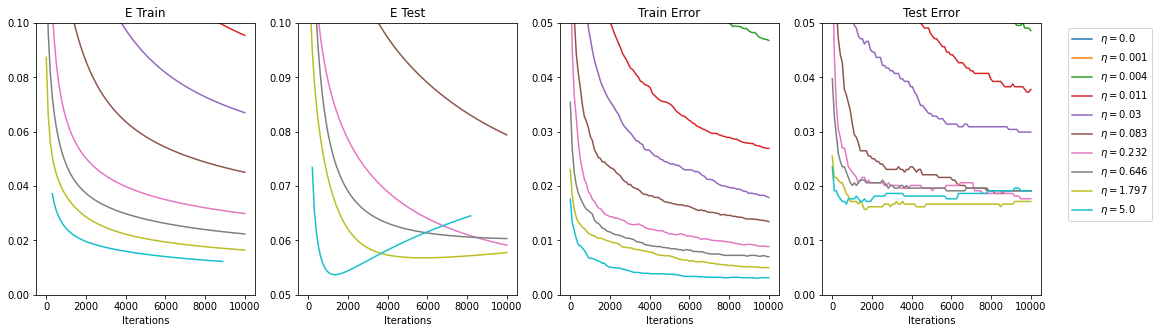

In [ ]:
fullplot(nruns,eta_vals,E_train_array_eta,E_test_array_eta,train_error_array_eta,test_error_array_eta)

From this plot we see that we should look for an eta of around 1, so next we try a linearly spaced eta array.

In [ ]:
# Linearly spaced eta between 0.5 and 1.5
eta_vals=np.linspace(0.5,1.5,10)

print(eta_vals)
nruns=10000
E_train_array_eta, E_test_array_eta, train_error_array_eta, test_error_array_eta = test_eta(d,eta_vals,nruns)

[0.5        0.61111111 0.72222222 0.83333333 0.94444444 1.05555556
 1.16666667 1.27777778 1.38888889 1.5       ]
Training regressor  0
 Iterations complete:  100.0 %Training regressor  1
 Iterations complete:  100.0 %Training regressor  2
 Iterations complete:  100.0 %Training regressor  3
 Iterations complete:  100.0 %Training regressor  4
 Iterations complete:  100.0 %Training regressor  5
 Iterations complete:  100.0 %Training regressor  6
 Iterations complete:  100.0 %Training regressor  7
 Iterations complete:  100.0 %Training regressor  8
 Iterations complete:  100.0 %Training regressor  9
 Iterations complete:  100.0 %

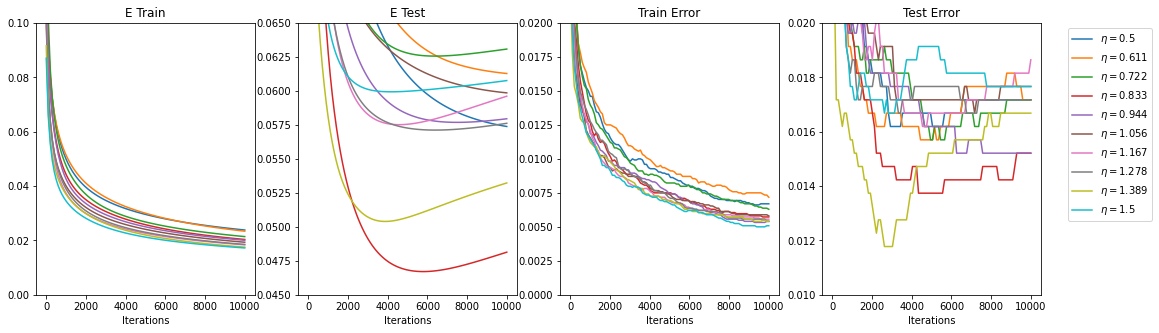

In [ ]:
fullplot(nruns,eta_vals,E_train_array_eta,E_test_array_eta,train_error_array_eta,test_error_array_eta)

#### Run regressor:

After testing for the best learning rate, we run the regressor for 10.000 iterations, with a learning rate of 1.

 Iterations complete:  100.0 %Time elapsed:  750.825119607
E_train:  0.020034689380310323
E_test:  0.055719561056487274
Error train:  0.5646982897708939 %
Error test:  1.7664376840039255 %


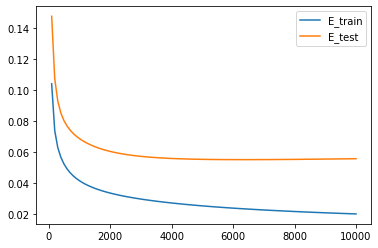

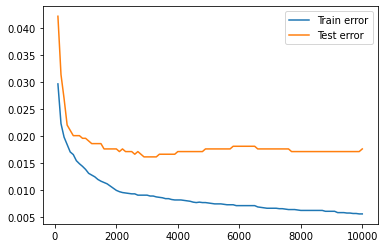

In [ ]:
tic()
regressor=Regressor(d,eta=1)
regressor.train(10000,x_train,y_train,x_test,y_test)
toc()

regressor.print_regressor()
regressor.plot_regressor()

We get:

E_train:  0.02

E_test:  0.056

Error train:  0.56%

Error test:  1.77%

Which is comparable to prof. Kappen's result.

Now we run the early stopping regressor, again with a learning rate of 1:

 Iterations complete:  64.0 %Early stopping

Time elapsed:  483.3114023999997
E_train:  0.02103592242719967
E_test:  0.053756312320389445
Error train:  0.6050338818973863 %
Error test:  1.521099116781158 %


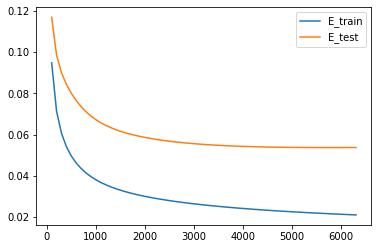

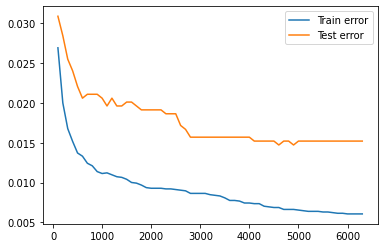

In [ ]:
tic()
regressor_stop=EarlyStopRegressor(d,eta=1)
regressor_stop.train(10000,x_train,y_train,x_test,y_test)
toc()

regressor_stop.print_regressor()
regressor_stop.plot_regressor()

It seems early stopping can be an effective technique when we do not save every weight vector for every epoch, which would be very memory costly.

### Momentum

*Add momentum to your gradient rule with strength $\alpha$ (see slides Machine Learning). Apply the method to the logistic regression problem. Produce plots of how $E$ decreases with iterations, both on the training set and on the test set. Test the effect of different values of $\alpha$, $\eta$.
Here are some results that I got after 10.000 iterations:*

$$E_{train} = 0.0114\qquad E_{test} = 0.0636$$

*The fraction of misclassified patterns is 0.78% and 2.07% on train and test set respectively. CPU time Matlab implementation was 45 s.*

The regressor with momentum requires a small adaptation to the update method.

In [7]:
class MomentumRegressor(Regressor):
  def __init__(self,d, eta, alpha):
    super().__init__(d,eta)
    self.w_prev=0
    self.alpha=alpha

  def update(self,x,t):
    g=Grad(x,t,self.w)
    self.w += -self.eta * g + self.alpha*self.w_prev
    self.w_prev=-self.eta*g

#### Test alpha functions

In [ ]:
def test_alpha(d,eta,alpha_vals, nruns):
  regressors = [MomentumRegressor(d,eta,alpha) for alpha in alpha_vals]

  E_train_array_alpha, E_test_array_alpha, train_error_array_alpha, test_error_array_alpha = [[] for _ in range(4)]

  for i,regressor in enumerate(regressors):
    
    print("\nTraining regressor ",i)
    print("Alpha: ",regressor.alpha)

    regressor.train(nruns,x_train,y_train,x_test,y_test)
  
    E_train_array_alpha.append(regressor.E_train_array)
    E_test_array_alpha.append(regressor.E_test_array)
    train_error_array_alpha.append(regressor.train_error_array)
    test_error_array_alpha.append(regressor.test_error_array)

  return np.array(E_train_array_alpha), np.array(E_test_array_alpha), np.array(train_error_array_alpha), np.array(test_error_array_alpha)


In [ ]:
def fullplotalpha(nruns,eta_vals,E_train_array_eta,E_test_array_eta,train_error_array_eta,test_error_array_eta):
  fig = plt.figure(figsize=(18,5))
  ax1 = fig.add_subplot(141)
  ax2 = fig.add_subplot(142)
  ax3 = fig.add_subplot(143)
  ax4 = fig.add_subplot(144)

  for e,et in enumerate(eta_vals):
    X = np.linspace(0,nruns,100)
    lab="$\alpha=$"+str(round(et,3))
    ax1.plot(X,E_train_array_eta[e,:],label=lab)
  ax1.set_title("E Train")
  ax1.set_xlabel("Iterations")
  ax1.set_xlabel("Iterations")
  ax1.set_ylim(0,0.1)

  for e,et in enumerate(eta_vals):
    X = np.linspace(0,nruns,100)
    lab="$\alpha=$"+str(round(et,3))
    ax2.plot(X,E_test_array_eta[e,:],label=lab)
  ax2.set_title("E Test")
  ax2.set_xlabel("Iterations")
  ax2.set_xlabel("Iterations")
  ax2.set_ylim(0.05,0.1)

  for e,et in enumerate(eta_vals):
    X = np.linspace(0,nruns,100)
    lab="$\alpha=$"+str(round(et,3))
    ax3.plot(X,train_error_array_eta[e,:],label=lab)
  ax3.set_title("Train Error")
  ax3.set_xlabel("Iterations")
  ax3.set_xlabel("Iterations")
  ax3.set_ylim(0,0.05)

  for e,et in enumerate(eta_vals):
    X = np.linspace(0,nruns,100)
    lab="$\alpha=$"+str(round(et,3))
    ax4.plot(X,test_error_array_eta[e,:],label=lab)
  ax4.set_title("Test Error")
  ax4.set_xlabel("Iterations")
  ax4.set_xlabel("Iterations")
  ax4.set_ylim(0,0.05)

  ax4.legend(bbox_to_anchor=(1.1, 1))

#### Eta = 0.8

In [ ]:
#linearly spaced alpha between 0.2 and 1
alpha_vals=np.linspace(0.2,1,5)

print(alpha_vals)
nruns=10000
E_train_array_alpha, E_test_array_alpha, train_error_array_alpha, test_error_array_alpha = test_alpha(d,0.8,alpha_vals,nruns)

[0.2 0.4 0.6 0.8 1. ]

Training regressor  0
Alpha:  0.2
 Iterations complete:  100.0 %
Training regressor  1
Alpha:  0.4
 Iterations complete:  100.0 %
Training regressor  2
Alpha:  0.6000000000000001
 Iterations complete:  100.0 %
Training regressor  3
Alpha:  0.8
 Iterations complete:  100.0 %
Training regressor  4
Alpha:  1.0
 Iterations complete:  100.0 %

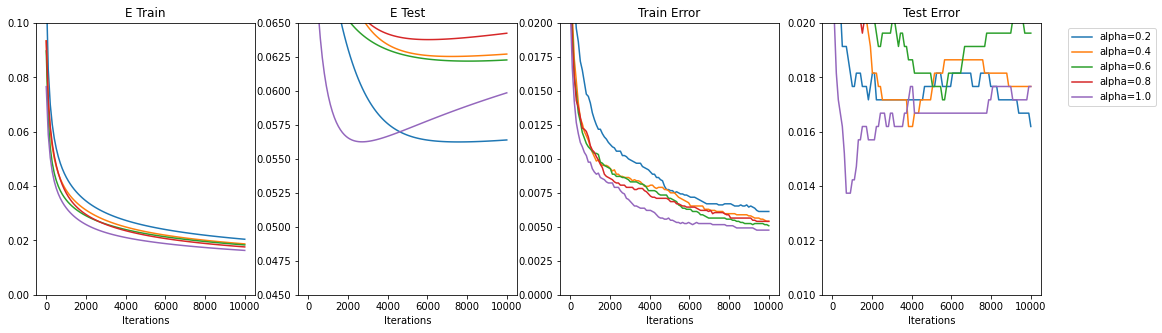

In [ ]:
fullplotalpha(nruns,alpha_vals,E_train_array_alpha, E_test_array_alpha, train_error_array_alpha, test_error_array_alpha)

#### Eta = 1

In [ ]:
#linearly spaced alpha between 0.2 and 1
alpha_vals=np.linspace(0.2,1,5)

print(alpha_vals)
nruns=10000
E_train_array_alpha, E_test_array_alpha, train_error_array_alpha, test_error_array_alpha = test_alpha(d,1,alpha_vals,nruns)

[0.2 0.4 0.6 0.8 1. ]

Training regressor  0
Alpha:  0.2
 Iterations complete:  100.0 %
Training regressor  1
Alpha:  0.4
 Iterations complete:  100.0 %
Training regressor  2
Alpha:  0.6000000000000001
 Iterations complete:  100.0 %
Training regressor  3
Alpha:  0.8
 Iterations complete:  100.0 %
Training regressor  4
Alpha:  1.0
 Iterations complete:  1.0 %

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


 Iterations complete:  100.0 %

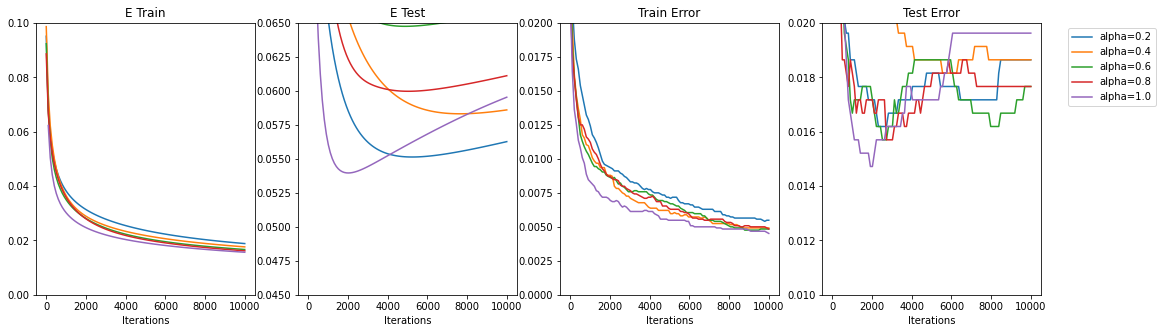

In [ ]:
fullplotalpha(nruns,alpha_vals,E_train_array_alpha, E_test_array_alpha, train_error_array_alpha, test_error_array_alpha)

#### Eta = 1.2

In [ ]:
#linearly spaced alpha between 0.2 and 1
alpha_vals=np.linspace(0.2,1,5)

print(alpha_vals)
nruns=10000
E_train_array_alpha, E_test_array_alpha, train_error_array_alpha, test_error_array_alpha = test_alpha(d,1.2,alpha_vals,nruns)

[0.2 0.4 0.6 0.8 1. ]

Training regressor  0
Alpha:  0.2
 Iterations complete:  100.0 %
Training regressor  1
Alpha:  0.4
 Iterations complete:  100.0 %
Training regressor  2
Alpha:  0.6000000000000001
 Iterations complete:  100.0 %
Training regressor  3
Alpha:  0.8
 Iterations complete:  100.0 %
Training regressor  4
Alpha:  1.0
 Iterations complete:  100.0 %

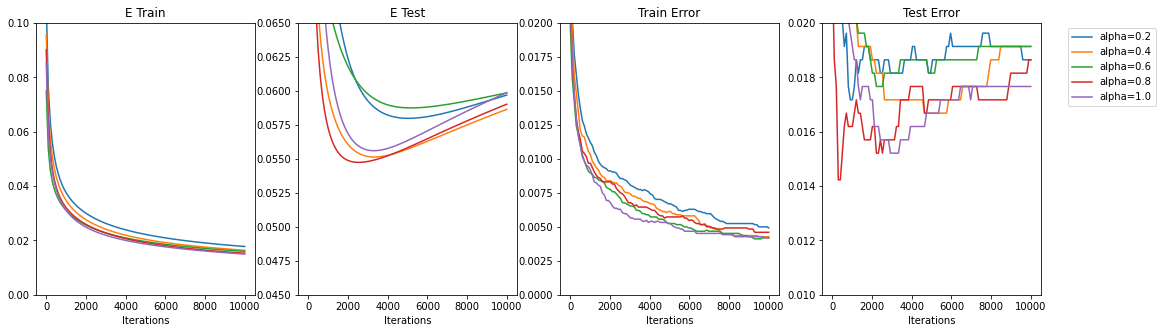

In [ ]:
fullplotalpha(nruns,alpha_vals,E_train_array_alpha, E_test_array_alpha, train_error_array_alpha, test_error_array_alpha)

#### Results

We try it here for 10.000 iterations, a learning rate of 1.2 and an alpha of 0.8.

 Iterations complete:  100.0 %
Time elapsed:  451.5327299370001
E_train:  0.015390975142820874
E_test:  0.05917511425817236
Error train:  0.47595998709261056 %
Error test:  1.6683022571148183 %


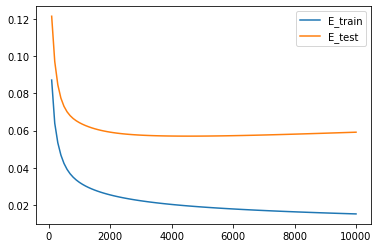

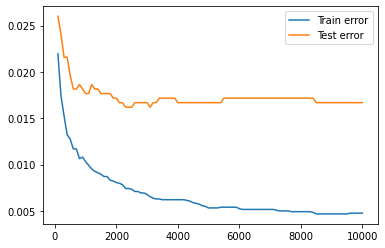

In [ ]:
tic()
regressor_momentum=MomentumRegressor(d,eta=1.2,alpha=0.8)
regressor_momentum.train(10000,x_train,y_train,x_test,y_test)
toc()

regressor_momentum.print_regressor()
regressor_momentum.plot_regressor()

Again this is very comparable.

### Weight decay

*Thus, we see that improving the optimization method using momentum decreases the
training error, but increases the test error. This indicates that the logistic regression
method is overfitting. We therefore add a weight decay term to E:*

$$E(w) = -\frac{1}{N}\sum^N_{n=1}[t^n log y^n + (1 − t^n) log(1 − y^n)] +\frac{\lambda}{2d}\sum^d_{i=0}w^2_i$$

In [ ]:
def decay_E(x,t,w,lamb=0.1):
  y=sigma(np.dot(x, w))
  N=len(y)
  d2=len(w)
  return -np.mean(t*np.log(y)+(1-t)*np.log(1-y))+1/(2*d2)*lamb*np.sum(w**2)

The Gradient and Hessian are

$$\nabla_i E(w) =\frac{\partial E}{\partial w_i}=\frac{1}{N}\sum^N_{n=1}(y^n − t^n)x^n_i+\frac{\lambda}{d}w_i \qquad i = 0, . . . , d$$

$$H_{ij}(w) =\frac{\partial^2E}{\partial w_i\partial w_j}=\frac{1}{N}\sum_n x^n_i y^n(1 − y^n)x^n_j+\frac{\lambda}{d}\delta_{ij} \qquad i, j = 0, . . . , d$$


In [9]:
def delta(i,j):
  if i==j:
    return 1
  else:
    return 0

def decay_Grad(x,t,w,lamb):
  y=predict(x,w)
  return np.expand_dims(np.mean((y-t)*x,axis=0),axis=1)+lamb/(d+1)*w

# Non vectorized Hessian
def decay_Hess(i,j,x,t,w):
  y=predict(x,w)
  return np.mean(x[:,[i]]*y*(1-y)*x[:,[j]])+0.1/(d+1)*delta(i,j)

def decay_getH(d,x,t,w):
  H=np.zeros((d+1,d+1))
  for i in range(d+1):
    for j in range(d+1):
      H[i,j]=decay_Hess(i,j,x,t,w)
  return H

# Vectorized Hessian
def decay_getHfast(x,w,lamb):
  y=predict(x,w)
  middlematrix=np.diagflat((y*(1-y)).T)
  H1=np.matmul(np.matmul(x.T, middlematrix),x)
  H2=np.diag(lamb/(d+1)*np.ones(d+1))
  return H1+H2

# Different vectorized Hessian
def Hessian_decay_partial(x,y):
  return np.sum(y[:,None,None]*(1-y[:,None,None])*np.einsum('...i,...j',x,x),axis=0)

# Split up to prevent RAM overflow
def Hessian_decay(x,w,lamb):
  y=np.squeeze(predict(x,w))
  splits=30
  z=np.zeros((d+1,d+1))
  x_s=np.array_split(x,splits)
  y_s=np.array_split(y,splits)
  for i in range(splits):
    z+=Hessian_decay_partial(x_s[i],y_s[i])
  z=z/N+np.diag(lamb/(d+1)*np.ones(d+1))
  return z

In [ ]:
def decay_Gradtest(x,t,w,lamb):
  y=predict(x,w)
  t=np.reshape(t,np.shape(y))
  ymint=np.reshape((y-t),(N,1))
  v1=np.matmul(ymint.T,x)/N
  v2=np.reshape(lamb/(d+1)*w, np.shape(v1))
  V=v1+v2
  return V

*Using λ = 0.1 and the momentum method, report E (with out the regularization term)
on both training and test set after convergence, number of iterations and total CPU
time. Send me the code so that I can check your reported performances of the various
methods.
I find after 5340 iteration on the training set E = 0.0218 and classification error
1.41% and on the test set E = 0.0467 and classification error 2.17%. Elapsed time is
26 seconds.
We now use this problem (λ = 0.1) and the results using gradient descend with
momentum to compare with other methods.*

In [8]:
class DecayRegressor(MomentumRegressor):
  def __init__(self,d, eta, alpha):
    super().__init__(d,eta,alpha)
    self.lamb=0.1

  def update(self,x,t):
    g=decay_Grad(x,t,self.w,self.lamb)
    self.w += -self.eta * g + self.alpha*self.w_prev
    self.w_prev=-self.eta*g

 Iterations complete:  100.0 %
Time elapsed:  1463.86198255
E_train:  0.022302167051012418
E_test:  0.046906286106806555
Error train:  0.6373023555985802 %
Error test:  1.5701668302257115 %


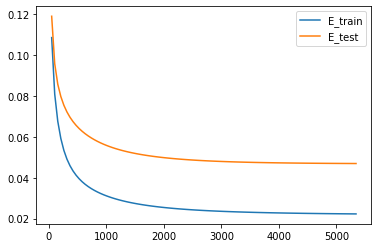

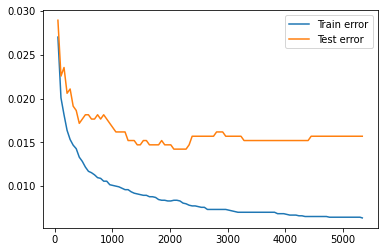

In [ ]:
tic()
regressor_decay=DecayRegressor(d,eta=1,alpha=1)
regressor_decay.train(5340,x_train,y_train,x_test,y_test)
toc()

regressor_decay.print_regressor()
regressor_decay.plot_regressor()

The result is better than obtained from professor Kappen's perceptron, but the simulation time is also quite a bit higher.

### Newton method

*Implement the Newton method $\Delta w=−H^{−1}(w)\nabla E$.
Apply the method to the logistic regression problem with weight decay. Produce plots of how $E$ decreases with iterations, both on the training set and on the test set.
I  find  after  10  iteration  on  the  training  set $E=0.0218$  and  classification  error $1.41\%$ and on the test set $E=0.0467$ and classification error $2.17\%$.  Elapsed time is 31 seconds. So this method requires far less iterations, but each iteration is much more expensive, so that the net result is not worth it.*



In [24]:
#Since we are using this for the regression problem with weight decay I'll have to use the decay_Hess and decay_Grad defined above
#inverting  the matrix will be the most time consuming step
# so instead we solve H(w)* x = -nabla E and set \delta w is x

class NewtonRegressor(Regressor):
  def __init__(self, d, eta):
    super().__init__(d, eta)
    self.checking_rate=30
    self.lamb=0.1

  def update(self,x,t):
    decayHess=np.squeeze(decay_getHfast(x,self.w,self.lamb))
    decaygrad=np.squeeze(decay_Grad(x,t,self.w,self.lamb))
    self.w += -np.expand_dims(np.linalg.solve(decayHess, decaygrad),axis=1)
    

 Iterations complete:  100.0 %
Time elapsed:  240.27448131100027
E_train:  1.948442906509031
E_test:  1.8884879431483812
Error train:  36.98773797999355 %
Error test:  35.91756624141315 %


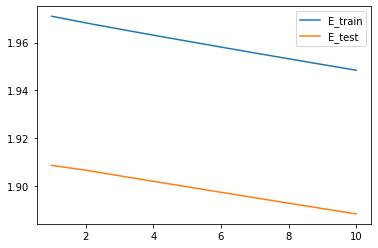

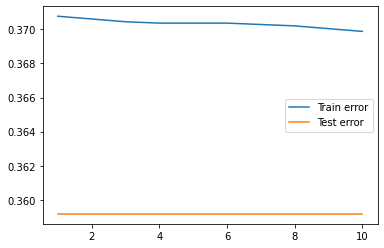

In [ ]:
tic()
regressor_newton=NewtonRegressor(d,eta=1)
regressor_newton.train(10,x_train,y_train,x_test,y_test)
toc()

regressor_newton.print_regressor()
regressor_newton.plot_regressor()

We were unable to get any error close to prof. Kappen's, with vectorized or unvectorized Hessians.

### Line search

*Implement the gradient method with line search. In each iteration compute the gradient at the current value of w: $d = -\nabla E(w)$. Then find numerically the value of $\gamma > 0$ such that $E(w+\gamma d)$ is minimized. This is a standard one dimensional optimization problem. For this, you can either write your own routine (for instance <url>http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/BMVA96Tut/node16.html</url>) or use a standard package. The main issue is to define the initial interval within which the minimum is searched. Apply the method to the logistic regression problem. Produce plots of how E decreases with iterations, both on the training set and on the test set. This method does not really converge well, but it is adapted with minor work to the conjugate gradient method discussed next. For the line search method I find after 224 iterations on the training set E = 0.0239 and classification error 1.50% and on the test set E = 0.0465 and classification error 2.19%. Elapsed time is 33 seconds.*

#### Line search using scipy optimize

In [ ]:
def LSE(w,x,t):
  w=np.expand_dims(w, axis=1)
  y=sigma(np.dot(x, w))
  return -np.mean(t*np.log(y)+(1-t)*np.log(1-y))

def LSGrad(w,x,t):
  w=np.expand_dims(w, axis=1)
  y=predict(x,w)
  return np.mean((y-t)*x,axis=0)

In [ ]:
class LSRegressor(Regressor):
    
  def update(self,x_t,t):
    # Fixing dimensions
    w=np.squeeze(self.w)

    g=LSGrad(w,x_t,t)
    d=-g

    # Optimizer
    args=(x_t,t)
    step = optimize.line_search(LSE, LSGrad, w, d, g, args=args)
    lab=step[0]

    # If LS algorithm does not converge, it returns none, this fixes that.
    if lab is None:
      lab=1

    self.w += -lab*np.expand_dims(g,axis=1)

 Iterations complete:  100.0 %
Time elapsed:  58.97051860500005
E_train:  0.026560138131496176
E_test:  0.05171097561798776
Error train:  0.8309131978057438 %
Error test:  1.5701668302257115 %


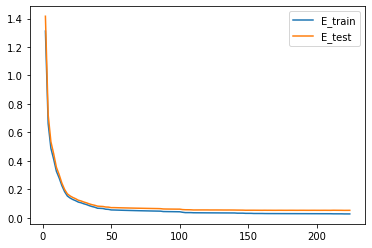

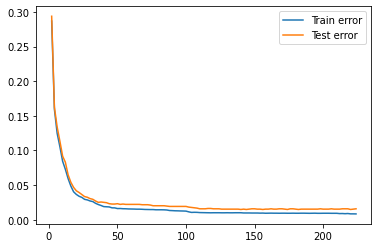

In [ ]:
tic()
regressor_ls=LSRegressor(d,eta=1)
regressor_ls.train(224,x_train,y_train,x_test,y_test)
toc()

regressor_ls.print_regressor()
regressor_ls.plot_regressor()

#### Line search with manual optimization

In [26]:
def LSminimum(x,t,w,N=50):
  # Calculating the negative gradient
  d0 = -Grad(x,t,w);
  # Generating an array of possible values for gamma
  gammapos = np.linspace(0,1,N)
  # Generating the w1s for all possible gammas
  wt=np.ones_like(gammapos)*w+gammapos*d0;
  # calculating y, without predict functions because of conflicting dimensions
  y=sigma(np.dot(x, wt));
  # temp and temp2 are fixing dimensions
  temp=np.expand_dims(y-np.ones(N)*t,axis=2);
  temp2=temp.swapaxes(1,2)*np.expand_dims(x,axis=2);
  # d1 for all possible gamma
  d1=np.mean(temp2,axis=0);
  # dot = the absolute value of the inner product of d0 and d1
  dot=np.abs(np.dot(d0.T,d1));
  # finding the index of the minimum of the absolute value of the inner product (so closest to 0)
  j=np.where(dot[0]==np.min(dot))[0][0]
  # calculating the final w1 and returning that
  w1 = w + gammapos[j]*d0;
  return w1;

The minimum  γ  is when  d0⋅d1=0 , where  di=−∇E(wi)  and  w1=w0+γ∗d0 . Calculating the  d0  can be simply done with the gradient function.  d1  is calculated much the same way, but we decided to get the code out of the function so we can compute  d1  for multiple values of  γ . Then we select value of  γ  that gives us the minimum of the absolute value of the inner product of  d0  and  d1 : the absolute value ensures we get the value closest to 0. Finally we calculate the new  w  with that value for  γ  and return it from this function.

In [27]:
class LineSearchRegressor():
  def __init__(self, d):
    self.d = d
    self.w = np.random.randn(d+1,1)
    self.checking_rate = 224;
    self.E_train=np.zeros(self.checking_rate)
    self.E_test=np.zeros(self.checking_rate)

  def train(self, x, t, nruns, testx, testt):
    for i in range(nruns):
      if i%int(nruns/self.checking_rate)==0:
        self.E_train[int(i/nruns*self.checking_rate)]=E(x,t,self.w)
        self.E_test[int(i/nruns*self.checking_rate)]=E(testx,testt,self.w)
        #print("\r","Iterations complete: ",i*100/nruns,"%,", "E_train=",E(x,t,self.w), end="")
      self.w = LSminimum(x,t,self.w,5)


In [28]:
tic()
regressor6=LineSearchRegressor(d)
regressor6.train(x_train,y_train,224,x_test,y_test)
toc()


Time elapsed:  112.42945484300003


As can be seen the program takes more than three times as long as the one by Bert. As we're using python and not matlab, it is expected to be slower, but it should be a difference of 20-30%.

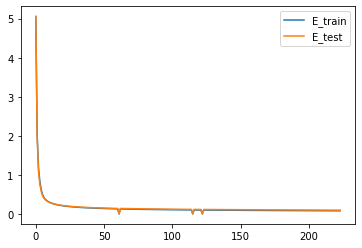

In [29]:
plt.plot(regressor6.E_train,label="E_train")
plt.plot(regressor6.E_test,label="E_test")
plt.legend()

### Conjugate gradient descent

*The conjugate gradient descent method uses the line search as a subroutine. In each step the search direction is $d = −\nabla E(w) + \beta d_{old}$. $\beta$ is given by the Polak-Ribiere rule (see slides Machine Learning). Implement the conjugate gradient method. Apply the method to the logistic regression problem. Produce plots of how E decreases with iterations, both on the training set and on the test set. I find after 106 iterations on the training set E = 0.0218 and classification error 1.41% and on the test set E = 0.0467 and classification error 2.17%. Elapsed time is 12 seconds. So this method converges fastest of all methods that we discussed.*

Polak-Ribbiere:

$$\beta=\frac{\left(\nabla E(w_1)-\nabla E(w_0)\right)\cdot \nabla E(w_1)}{\lVert\nabla E(w_1)\rVert^2}$$

In [ ]:
class ConjRegressor(Regressor):
  def __init__(self,d, eta):
    super().__init__(d,eta)
    self.g_prev=None
    self.d_old=0

  def update(self,x_t,t):
    # Fixing dimensions
    w=np.squeeze(self.w)
    
    g=LSGrad(w,x_t,t)
    # Check whether it's the first iteration
    if self.g_prev is None:
      d=-g
    else:
      # Polak Ribbiere
      beta=np.dot((g-self.g_prev),g)/np.dot(g,g)
      d=-g+beta*self.d_old

    # Optimizer
    args=(x_t,t)
    step = optimize.line_search(LSE, LSGrad, w, d, g, args=args)
    lab=step[0]

    # If LS algorithm does not converge, it returns none, this fixes that.
    if lab is None:
      lab=1
    
    # Save old values
    self.g_prev=g
    self.d_old=d

    # Update
    self.w += -lab*np.expand_dims(g,axis=1)
    

 Iterations complete:  100.0 %
Time elapsed:  29.71297029499999
E_train:  0.03207164618705587
E_test:  0.05631369482879872
Error train:  0.9761213294611165 %
Error test:  1.422963689892051 %


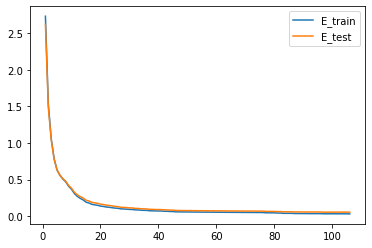

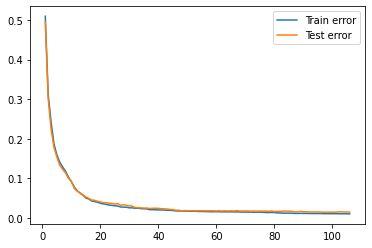

In [ ]:
tic()
regressor_cj=ConjRegressor(d,eta=1)
regressor_cj.train(106,x_train,y_train,x_test,y_test)
toc()

regressor_cj.print_regressor()
regressor_cj.plot_regressor()

### Stochastic gradient descent

*In the above, so called batch methods, the computation of the gradient requires time linear in the size of the data set. When the data set is large, this can be a significant cost. The stochastic gradient descent method only uses a subset of the total data set (sometimes called mini batch. Implement the stochastic gradient descent method. Apply the method to the logistic regression problem. Consider constant learning rate $\eta$ and mini batch sizes. Produce plots of how E decreases with iterations, both on the training set and on the test set for different values of $\eta$.
I find with mini batch size of 0.01N after 5000 iteration on the training set E = 0.0243 and classification error 1.36% and on the test set E = 0.0499 and classification error 2.02%. Elapsed time is 5 seconds.*

In [ ]:
int(0.01*N)

123

Now we take the normal regressor class and take a random subset of N of the size 0.01*N=123

In [ ]:
class SGDRegressor(Regressor):
  def __init__(self,d, eta):
    super().__init__(d,eta)
    self.batch_size=123

  def update(self,x,t):
    subset=np.random.choice(x.shape[0], self.batch_size, replace=False)
    t=t[subset]
    x=x[subset]
    self.w += -self.eta * Grad(x,t,self.w)

 Iterations complete:  100.0 %
Time elapsed:  8.93498875399996
E_train:  0.024656881876468067
E_test:  0.06128551741898793
Error train:  0.8147789609551468 %
Error test:  1.717369970559372 %


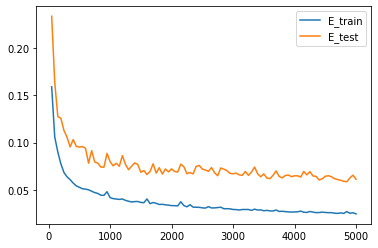

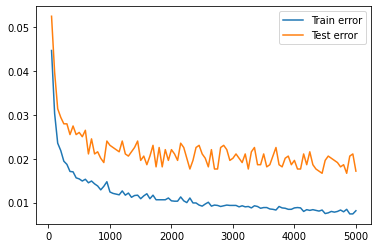

In [ ]:
tic()
regressor_sgd=SGDRegressor(d,eta=1)
regressor_sgd.train(5000,x_train,y_train,x_test,y_test)
toc()

regressor_sgd.print_regressor()
regressor_sgd.plot_regressor()

#### Test for different values of eta:

In [ ]:
def test_eta_SGD(d,eta_vals, nruns):
  regressors = [SGDRegressor(d,eta) for eta in eta_vals]

  E_train_array_eta, E_test_array_eta, train_error_array_eta, test_error_array_eta = [[] for _ in range(4)]

  for i,regressor in enumerate(regressors):

    print("\nTraining regressor ",i)

    regressor.train(nruns,x_train,y_train,x_test,y_test)
  
    E_train_array_eta.append(regressor.E_train_array)
    E_test_array_eta.append(regressor.E_test_array)
    train_error_array_eta.append(regressor.train_error_array)
    test_error_array_eta.append(regressor.test_error_array)

  return np.array(E_train_array_eta), np.array(E_test_array_eta), np.array(train_error_array_eta), np.array(test_error_array_eta)



First test an exponentially spaced learning rate, to check several orders of magnitude of potential learning rates

In [ ]:
# Exponentially spaced eta between 0.001 and 1 for nruns=50k
eta_vals=0.001*10**(np.linspace(0,3,4))
print(eta_vals)
nruns=50000
E_train_array_eta, E_test_array_eta, train_error_array_eta, test_error_array_eta = test_eta_SGD(d,eta_vals,nruns)

[0.001 0.01  0.1   1.   ]

Training regressor  0
 Iterations complete:  100.0 %
Training regressor  1
 Iterations complete:  100.0 %
Training regressor  2
 Iterations complete:  100.0 %
Training regressor  3
 Iterations complete:  100.0 %

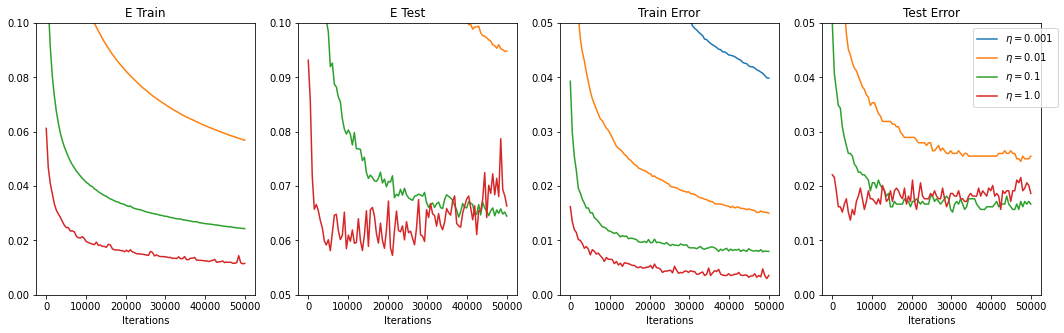

In [ ]:
fullplot(nruns,eta_vals,E_train_array_eta,E_test_array_eta,train_error_array_eta,test_error_array_eta)

Seems optimal value is again around $\eta$=1, so next we test here

In [ ]:
# Linearly spaced eta between 0.75 and 1.25
eta_vals=np.linspace(0.5,1.5,5)

print(eta_vals)
nruns=50000
E_train_array_eta, E_test_array_eta, train_error_array_eta, test_error_array_eta = test_eta_SGD(d,eta_vals,nruns)

[0.5  0.75 1.   1.25 1.5 ]

Training regressor  0
 Iterations complete:  100.0 %
Training regressor  1
 Iterations complete:  100.0 %
Training regressor  2
 Iterations complete:  79.0 %

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


 Iterations complete:  100.0 %
Training regressor  3
 Iterations complete:  100.0 %
Training regressor  4
 Iterations complete:  100.0 %

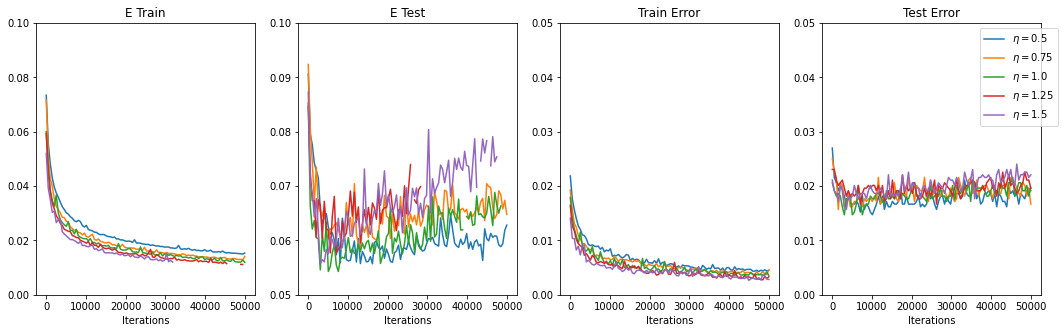

In [ ]:
fullplot(nruns,eta_vals,E_train_array_eta,E_test_array_eta,train_error_array_eta,test_error_array_eta)

It seems that they all perform similarly for a value around $\eta=1$

*Discuss how the results for this problem (logistic regression on the MNIST data) are expected to change for other data sets (more samples or more variables) and methods (more variables such as deep neural networks)*




Increasing the amount of samples shouldn't change the results much. It might increase the runtime in the the non-stochastic gradient descent, but if the implementations are decently efficient this shouldn't be too much of a problem. The MNIST dataset is actually quite small, and an extended version with 240000 training samples and 40000 test samples was published in 2017. More training samples might generalise better so the final error rate would be lower.

Increasing the number of variables in the dataset does of course make the problem more complicated and would slow down the learning. These simple logistic regression models would not perform as well on the cifar10 dataset, as can be seen next in the literature next week where a one layer perceptron has an almost 50 percent error rate.

Adding different methods such as multiple layers, especially convolutional layers can decrease the error on the test set to less than one percent, so there is some gain to be gotten there.




